In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import matplotlib.pyplot as plt
from functools import partial
from algorithms.tqdm_custom import scan_tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
import seaborn as sns

from plotly_resampler import register_plotly_resampler, FigureWidgetResampler
# register_plotly_resampler(mode="auto", default_n_shown_samples=4500)

import pandas as pd

from algorithms.utils import restore_state, restore_state_multi_agent

import numpy as np

import jax
import jax.numpy as jnp

import flax.nnx as nnx
from flax.core.frozen_dict import freeze
# jax.config.update("jax_enable_x64", True)


2025-03-28 16:51:40.546151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743177100.559709    9076 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743177100.563672    9076 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from ernestogym.envs_jax.multi_agent.env import RECEnv
# from ernestogym.envs_jax.single_agent.env_trading_soc import MicroGridEnvSocAction

In [4]:
def my_env_creator(params, battery_type, env_type='normal'):
    if env_type == 'normal':
        env = RECEnv(params, battery_type)
    return env

In [5]:
def print_heatmap(X, Y, Z, num_bins=10, x_label='', y_label='', title='', n_decimals_axes=0):
    z_grid, y_edges, x_edges = np.histogram2d(Y, X, bins=(num_bins, num_bins), weights=Z)
    counts, _, _ = np.histogram2d(Y, X, bins=(num_bins, num_bins))

    z_grid = np.divide(z_grid, counts, out=np.full_like(z_grid, fill_value=np.nan), where=counts > 0)

    x_centers = (x_edges[1:]+x_edges[:-1])/2
    y_centers = (y_edges[1:]+y_edges[:-1])/2

    x_ticks = [f'{v:.{n_decimals_axes}f}' for v in x_centers]
    y_ticks = [f'{v:.{n_decimals_axes}f}' for v in y_centers]

    plt.figure(figsize=(8, 6))
    sns.heatmap(z_grid, xticklabels=x_ticks, yticklabels=y_ticks, cmap='coolwarm', center=0).invert_yaxis()

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def plot_hist_soc(soc, actions):
    hist, bins = np.histogram(soc, weights=actions, bins=16)
    counts, _ = np.histogram(soc, bins=16)

    hist = np.divide(hist, counts, where=counts > 0)

    bins_ctrs = (bins[:-1] + bins[1:])/2

    plt.bar(bins_ctrs, hist, width=0.045)

    plt.xlabel('SoC')
    plt.ylabel('Mean action')

In [6]:
from ernestogym.envs_jax.multi_agent.utils import get_world_data

In [7]:
num_iter = 8760 * 5

# Testing

In [8]:
logs = {}
experiments = []
agents = {}

In [9]:
@partial(jax.jit, static_argnums=(0, 1, 2, 3, 4))
def test(env:RECEnv, networks_batteries, network_rec, num_iter, config, rng):

    networks_batteries.eval()
    network_rec.eval()

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    if config['NETWORK_TYPE_BATTERIES'] == 'recurrent_actor_critic':
        init_act_state_batteries, init_cri_state_batteries = networks_batteries.get_initial_lstm_state()
        act_state_batteries, cri_state_batteries = init_act_state_batteries, init_cri_state_batteries
    else:
        act_state_batteries, cri_state_batteries = None, None

    if config['NETWORK_TYPE_REC'] == 'recurrent_actor_critic':
        init_act_state_rec, init_cri_state_rec = network_rec.get_initial_lstm_state()
        act_state_rec, cri_state_rec = init_act_state_rec, init_cri_state_rec
    else:
        act_state_rec, cri_state_rec = None, None

    @scan_tqdm(0, 0, 1, num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, iter):
        obsv_batteries, env_state, act_state_batteries, act_state_rec, rng, next_profile_index = runner_state

        # print('aaaaa', obsv_batteries[:config['NUM_RL_AGENTS']].shape)

        if config['NETWORK_TYPE_BATTERIES'] == 'recurrent_actor_critic':
            pi, _, act_state_batteries, _ = networks_batteries(obsv_batteries[:config['NUM_RL_AGENTS']], act_state_batteries, cri_state_batteries)
        else:
            pi, _ = networks_batteries(obsv_batteries[:config['NUM_RL_AGENTS']])

        #deterministic action
        actions_batteries_rl = pi.mode()

        # print('act 1', actions_batteries_rl.shape)
        actions_batteries_rl = actions_batteries_rl.squeeze(axis=-1)

        # print('act', actions_batteries_rl.shape)


        actions_batteries = [actions_batteries_rl]

        if config['NUM_BATTERY_FIRST_AGENTS'] > 0:
            idx_start_bf = config['NUM_RL_AGENTS']
            idx_end_bf = config['NUM_RL_AGENTS'] + config['NUM_BATTERY_FIRST_AGENTS']

            demand = runner_state.last_obs_batteries[:, idx_start_bf:idx_end_bf, env._obs_battery_agents_idx['demand']]
            generation = runner_state.last_obs_batteries[:, idx_start_bf:idx_end_bf,
                         env._obs_battery_agents_idx['generation']]

            actions_batteries_battery_first = (generation - demand) / runner_state.env_state.battery_states.electrical_state.v[:, idx_start_bf:idx_end_bf]

            actions_batteries.append(actions_batteries_battery_first)

        if config['NUM_ONLY_MARKET_AGENTS'] > 0:
            actions_batteries_only_market = jnp.zeros(
                (config['NUM_ONLY_MARKET_AGENTS'], config['BATTERY_ACTION_SPACE_SIZE']))
            actions_batteries.append(actions_batteries_only_market)

        if config['NUM_RANDOM_AGENTS'] > 0:
            rng, _rng = jax.random.split(rng)
            idx_start_random = config['NUM_RL_AGENTS'] + config['NUM_BATTERY_FIRST_AGENTS'] + config[
                'NUM_ONLY_MARKET_AGENTS']

            actions_batteries_random = jax.random.uniform(_rng,
                                                          shape=(config['NUM_RANDOM_AGENTS'],),
                                                          minval=-1.,
                                                          maxval=1.)

            actions_batteries_random *= config['MAX_ACTION_RANDOM_AGENTS']

            actions_batteries.append(actions_batteries_random)

        actions_batteries = jnp.concat(actions_batteries, axis=0)


        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        rec_obsv = obsv[env.rec_agent]

        if config['NETWORK_TYPE_REC'] == 'recurrent_actor_critic':
            pi, _, act_state_rec, _ = network_rec(rec_obsv, act_state_rec, cri_state_rec)
        else:
            pi, _ = network_rec(rec_obsv)

        actions_rec = pi.mean()

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec
        info['dones'] = jax.tree.map(lambda x, y : jnp.logical_or(x, y), done_first, done_second)

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        obs_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

        runner_state = (obs_batteries, env_state, act_state_batteries, act_state_rec, rng, next_profile_index)
        return runner_state, info

    obsv_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

    runner_state = (obsv_batteries, env_state, act_state_batteries, act_state_rec, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [10]:
directory = '/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250328_164847_bat_net_type_actor_critic_rec_net_type_actor_critic_lr_bat_1e-05_lr_REC_cosine_tot_timesteps_70080_lr_sched_cosine_multiagent'

curr_exp = 'exp1'
experiments.append(curr_exp)

networks_batteries, network_rec, config, world_metadata, train_info, val_info = restore_state_multi_agent(directory)

print(world_metadata)

test_params = get_world_data(world_metadata, get_test=True)
battery_type = 'degrading_dropflow'

curr_agents = []
curr_agents += ['recurrent_ppo_agent_' if config['NETWORK_TYPE_BATTERIES'] == 'recurrentactor_critic' else 'ppo_agent' + str(i) for i in range(config['NUM_RL_AGENTS'])]
curr_agents += ['battery_first_agent_' + str(i) for i in range(config['NUM_BATTERY_FIRST_AGENTS'])]
curr_agents += ['only_market_agent_' + str(i) for i in range(config['NUM_ONLY_MARKET_AGENTS'])]
curr_agents += ['random_agent_' + str(i) for i in range(config['NUM_RANDOM_AGENTS'])]

agents[curr_exp] = curr_agents

norm batt
norm rec
WorldMetadata(world_train={'num_battery_houses': 4, 'battery_observations': ['demand', 'generation', 'temperature', 'soc', 'day_of_year', 'seconds_of_day', 'selling_price', 'buying_price', 'network_REC_diff'], 'rec_observations': ['demands_base_battery_houses', 'demands_battery_battery_houses', 'generations_base_battery_houses', 'mean_demands_base', 'mean_demands_batteries', 'mean_generations', 'day_of_year', 'seconds_of_day', 'network_REC_plus', 'network_REC_minus', 'rec_actions_prev_step'], 'demand': {'path': 'ernestogym/ernesto_jax/data/demand/rse_profiles_train.csv', 'timestep': 3600, 'test_profiles': None, 'data_usage': 'end'}, 'generation': {'path': {'battery_houses_generation': ['ernestogym/ernesto_jax/data/generation/Timeseries_45.235_10.693_SA3_3kWp_crystSi_14_30deg_-60deg_2015_2018._train.csv', 'ernestogym/ernesto_jax/data/generation/Timeseries_45.235_10.693_SA3_3kWp_crystSi_14_30deg_0deg_2015_2018._train.csv', 'ernestogym/ernesto_jax/data/generation/Timese

In [11]:
networks_batteries.log_std

Param(
  value=Array([[-0.0014827 ],
         [-0.0014194 ],
         [-0.00117111],
         [-0.00092928]], dtype=float32)
)

In [12]:
config

{'ACTIVATION': 'tanh',
 'BATTERY_ACTION_SPACE_SIZE': 1,
 'BATTERY_NUM_SEQUENCES': 7,
 'BATTERY_OBSERVATION_SPACE_SIZE': 11,
 'BATTERY_OBS_IS_NORMALIZABLE': (True,
  False,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False),
 'CLIP_EPS': 0.2,
 'DEBUG': False,
 'ENT_COEF': 0.0,
 'ENV_NAME': None,
 'ENV_TYPE': 'normal',
 'FRACTION_DYNAMIC_LR_BATTERIES': 0.7,
 'FRACTION_DYNAMIC_LR_REC': 1.0,
 'GAE_LAMBDA': 0.98,
 'GAMMA': 0.99,
 'LOGISTIC_FUNCTION_TO_ACTOR': False,
 'LR_BATTERIES': 1e-05,
 'LR_BATTERIES_MIN': 1e-07,
 'LR_REC': 0.0001,
 'LR_REC_MIN': 1e-06,
 'LR_SCHEDULE': 'cosine',
 'LSTM_ACTIVATION': 'tanh',
 'LSTM_NET_ARCH': (24, 12),
 'MAX_ACTION_RANDOM_AGENTS': 4.0,
 'MAX_GRAD_NORM': 0.5,
 'MINIBATCH_SIZE': 1024,
 'NETWORK_TYPE_BATTERIES': 'actor_critic',
 'NETWORK_TYPE_REC': 'actor_critic',
 'NET_ARCH': (64, 32, 16),
 'NORMALIZE_ADVANTAGES': True,
 'NORMALIZE_ENV': False,
 'NORMALIZE_NN_INPUTS': True,
 'NORMALIZE_REWARD_FOR_GAE_AND_TARGETS': False,
 'NORMALIZE

In [13]:
world_metadata

WorldMetadata(world_train={'num_battery_houses': 4, 'battery_observations': ['demand', 'generation', 'temperature', 'soc', 'day_of_year', 'seconds_of_day', 'selling_price', 'buying_price', 'network_REC_diff'], 'rec_observations': ['demands_base_battery_houses', 'demands_battery_battery_houses', 'generations_base_battery_houses', 'mean_demands_base', 'mean_demands_batteries', 'mean_generations', 'day_of_year', 'seconds_of_day', 'network_REC_plus', 'network_REC_minus', 'rec_actions_prev_step'], 'demand': {'path': 'ernestogym/ernesto_jax/data/demand/rse_profiles_train.csv', 'timestep': 3600, 'test_profiles': None, 'data_usage': 'end'}, 'generation': {'path': {'battery_houses_generation': ['ernestogym/ernesto_jax/data/generation/Timeseries_45.235_10.693_SA3_3kWp_crystSi_14_30deg_-60deg_2015_2018._train.csv', 'ernestogym/ernesto_jax/data/generation/Timeseries_45.235_10.693_SA3_3kWp_crystSi_14_30deg_0deg_2015_2018._train.csv', 'ernestogym/ernesto_jax/data/generation/Timeseries_45.235_10.693_

In [14]:
test_params

{'num_battery_agents': 4,
 'num_passive_houses': 1,
 'batteries': [{'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 288.0,
    'temp_ambient': 298.15,
    'nominal_cost': 1500.0},
   'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
    'current': {'low': -180.0, 'high': 60.0},
    'power': {'low': -71712.0, 'high': 23904.0},
    'temperature': {'low': 273.15, 'high': 323.15},
    'temp_ambient': {'low': 273.15, 'high': 323.15},
    'soc': {'low': 0.2, 'high': 1.0},
    'soh': {'low': 0.6, 'high': 1.0}},
   'init': {'voltage': 310.8,
    'current': 0.0,
    'power': 0.0,
    'temperature': 293.15,
    'temp_ambient': 293.15,
    'soc': 0.5,
    'soh': 1.0}},
  {'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 2

In [15]:
env = my_env_creator(test_params, battery_type, config['ENV_TYPE'])

norm? False
['temperature', 'soc', 'demand', 'generation', 'buying_price', 'selling_price', 'network_REC_diff', 'sin_day_of_year', 'cos_day_of_year', 'sin_seconds_of_day', 'cos_seconds_of_day']
['demands_base_battery_houses', 'demands_battery_battery_houses', 'generations_battery_houses', 'mean_demands_base', 'mean_demands_batteries', 'mean_generations', 'sin_day_of_year', 'cos_day_of_year', 'sin_seconds_of_day', 'cos_seconds_of_day', 'network_REC_plus', 'network_REC_minus', 'rec_actions_prev_step']


In [16]:
from time import time
t0 = time()
info = test(env, networks_batteries, network_rec, num_iter, freeze(config), jax.random.PRNGKey(51))
print(time() - t0)
logs[curr_exp] = info

Running for 43,800 iterations:   0%|          | 0/43800 [00:00<?, ?it/s]

33.09535360336304


In [17]:
info

{'actions_batteries': Array([[ 0.0400212 ,  0.00635171,  0.06687448, -0.01513011],
        [ 0.0455856 ,  0.00202551,  0.06454864, -0.01369391],
        [ 0.04552913, -0.00056653,  0.05883868, -0.0108994 ],
        ...,
        [ 0.02152772,  0.03017835,  0.02926559, -0.07258167],
        [ 0.01743698,  0.04257255,  0.03456654, -0.06835724],
        [ 0.02848171,  0.00419284,  0.04786941, -0.05171191]],      dtype=float32),
 'actions_rec': Array([[0.25046834, 0.24984701, 0.2498094 , 0.2498753 ],
        [0.2501229 , 0.24997893, 0.24992906, 0.24996912],
        [0.24999489, 0.2499478 , 0.2500968 , 0.2499605 ],
        ...,
        [0.2500721 , 0.25006205, 0.24998136, 0.24988456],
        [0.2504826 , 0.24967209, 0.250088  , 0.24975733],
        [0.2504474 , 0.2496618 , 0.25016087, 0.24972996]], dtype=float32),
 'balance_minus': Array([1153.8728, 1586.0277, 2754.0742, ..., 3703.4695, 4267.407 ,
        4282.423 ], dtype=float32, weak_type=True),
 'balance_plus': Array([0., 0., 0., ..., 0

In [18]:
# jax.tree.map(lambda x : x.shape, info)

In [19]:
info['demands'].shape

(43800, 4)

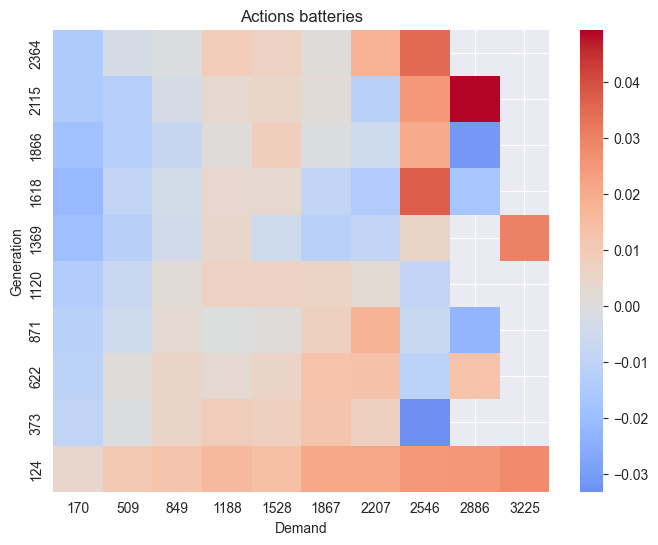

In [20]:
print_heatmap(info['demands'][:, :config['NUM_RL_AGENTS']].flatten(), info['generations'][:, :config['NUM_RL_AGENTS']].flatten(), info['actions_batteries'][:, :config['NUM_RL_AGENTS']].flatten(), x_label='Demand', y_label='Generation', title='Actions batteries')

In [21]:
info['r_glob'].mean(), info['r_glob'].max(), info['r_glob'].min()

(Array(0.00637331, dtype=float32),
 Array(0.08313806, dtype=float32),
 Array(0., dtype=float32))

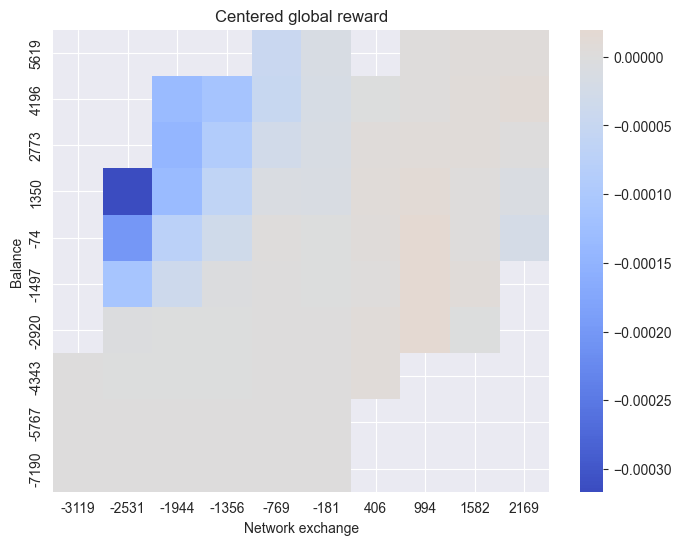

In [22]:
net_exchange = info['generations']-info['demands']-info['energy_to_batteries']

print_heatmap(net_exchange[:, :config['NUM_RL_AGENTS']].T.flatten(), np.tile(info['balance_plus'] - info['balance_minus'], reps=config['NUM_RL_AGENTS']), (info['r_glob'][:, :config['NUM_RL_AGENTS']] - info['r_glob'].mean(axis=1, keepdims=True)).T.flatten(), x_label='Network exchange', y_label='Balance', title='Centered global reward') #, num_bins=9)

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


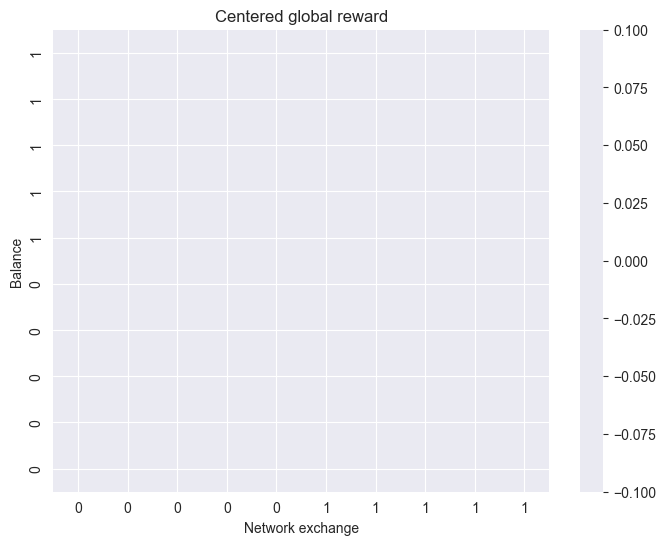

In [23]:
print_heatmap(net_exchange[:, config['NUM_RL_AGENTS']:].T.flatten(), np.tile(info['balance_plus'] - info['balance_minus'], reps=config['NUM_BATTERY_AGENTS']-config['NUM_RL_AGENTS']), (info['r_glob'][:, config['NUM_RL_AGENTS']:] - info['r_glob'].mean(axis=1, keepdims=True)).T.flatten(), x_label='Network exchange', y_label='Balance', title='Centered global reward') #, num_bins=25)

In [24]:
# print_heatmap(net_exchange[:, :config['NUM_RL_AGENTS']].T.flatten(), np.tile(info['balance_plus'] - info['balance_minus'], reps=config['NUM_RL_AGENTS']), info['r_glob'][:, :config['NUM_RL_AGENTS']].T.flatten(), x_label='Network exchange', y_label='Balance', title='Actions REC')

In [25]:
# print_heatmap(net_exchange[:, config['NUM_RL_AGENTS']:].T.flatten(), np.tile(info['balance_plus'] - info['balance_minus'], reps=config['NUM_BATTERY_AGENTS']-config['NUM_RL_AGENTS']), info['actions_rec'][:, config['NUM_RL_AGENTS']:].T.flatten(), x_label='Network exchange', y_label='Balance', title='Actions REC')

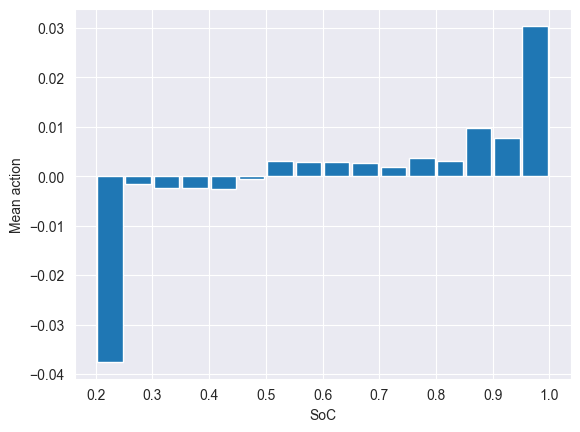

In [26]:
plot_hist_soc(info['soc'].flatten(), info['actions_batteries'].flatten())

# Plotting

In [27]:
logs = jax.tree.map(lambda x : np.asarray(x), logs)


In [28]:
exp = []

print('Tot self consumption')
for e in exp:
    print(f'\t{e}: {np.sum(logs[e]['self_consumption'])}')

print('Tot reward')
for e in exp:
    print(f'\t{e}: {np.sum(logs[e]['r_tot'])}')

print('Tot glob reward')
for e in exp:
    print(f'\t{e}: {np.sum(logs[e]['r_glob'])}')

print('Tot trad reward')
for e in exp:
    print(f'\t{e}: {np.sum(logs[e]['weig_reward']['r_trad'])}')

print('Tot deg reward')
for e in exp:
    print(f'\t{e}: {np.sum(logs[e]['weig_reward']['r_deg'])}')

print('Tot clipping reward')
for e in exp:
    print(f'\t{e}: {np.sum(logs[e]['weig_reward']['r_clipping'])}')

print('Tot rec reward')
for e in exp:
    print(f'\t{e}: {np.sum(logs[e]['rec_reward'])}')

print('\n\n')

print('Mean rec actions')
for e in exp:
    print(f'\t{e}: {np.mean(logs[e]['actions_rec'], axis=0)}')
print('Mean of variance rec actions')
for e in exp:
    print(f'\t{e}: {np.mean(np.var(logs[e]['actions_rec'], axis=1))}')
print('Mean of difference max-min rec actions')
for e in exp:
    print(f'\t{e}: {np.mean(np.max(logs[e]['actions_rec'], axis=1) - np.min(logs[e]['actions_rec'], axis=1))}')

print('Pearson correlation coeff')
for e in exp:
    v1 = logs[e]['actions_rec']
    v2 = (logs[e]['generations']-logs[e]['demands']-logs[e]['energy_to_batteries']) * (logs[e]['balance_plus'] - logs[e]['balance_minus'])[:, None]
    coeff = np.mean((v1 - v1.mean(axis=0, keepdims=True)) * (v2 - v2.mean(axis=0, keepdims=True)), axis=0)
    norm_coeff = coeff/np.sqrt(np.var(v1, axis=0)*np.var(v2, axis=0))
    print(f'\t{e}: {coeff}\t\t{norm_coeff}')


Tot self consumption
Tot reward
Tot glob reward
Tot trad reward
Tot deg reward
Tot clipping reward
Tot rec reward



Mean rec actions
Mean of variance rec actions
Mean of difference max-min rec actions
Pearson correlation coeff


In [29]:
import statsmodels.api as sm

e = 'exp1'

a = logs[e]['actions_rec'][:, :config['NUM_RL_AGENTS']].T.flatten()
b = (logs[e]['generations'][:, :config['NUM_RL_AGENTS']]-logs[e]['demands'][:, :config['NUM_RL_AGENTS']]-logs[e]['energy_to_batteries'][:, :config['NUM_RL_AGENTS']]).T.flatten()
c = np.tile(logs[e]['balance_plus'] - logs[e]['balance_minus'], reps=config['NUM_RL_AGENTS'])

print(np.corrcoef(b, c)[0, 1])

X = np.column_stack((b, c, b * c))  # Independent variables
X = sm.add_constant(X)  # Add intercept
model = sm.OLS(a, X).fit()

print(model.summary())

0.7248296615964838
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3929.
Date:                Fri, 28 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:52:31   Log-Likelihood:             1.2049e+06
No. Observations:              175200   AIC:                        -2.410e+06
Df Residuals:                  175196   BIC:                        -2.410e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2500   7.23e-07 

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = np.column_stack((b, c, b * c))
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif)

[2.265010207737792, 2.1229042885164024, 1.1068121673487423]


In [31]:
v1 = logs['exp1']['actions_rec'][:, 0]
v2 = (logs['exp1']['generations'][:, 0]-logs['exp1']['demands'][:, 0]-logs['exp1']['energy_to_batteries'][:, 0]) * (logs['exp1']['balance_plus'] - logs['exp1']['balance_minus'])

print(np.corrcoef(v1, v2))

print(v1.shape)
print(v2.shape)


np.mean((v1-v1.mean()) * (v2-v2.mean())) / np.sqrt(np.var(v1)*np.var(v2))

[[1.         0.14688989]
 [0.14688989 1.        ]]
(43800,)
(43800,)


0.14688988

In [32]:
# exp = ['random', 'only_market', 'battery_first', 'ppo', 'recurrent_ppo']        #, 'recurrent_ppo']
# colors = {e: col for e, col in zip(es, plotly.colors.sample_colorscale('rainbow', len(es)))}
colors = plotly.colors.sample_colorscale('rainbow', env.num_battery_agents)
line_styles = {'exp1': 'dot',
               'only_market': 'dash',
               'battery_first': 'dashdot',
               'ppo': 'solid',
               'recurrent_ppo': 'longdash'}

def plot_data_plotly(demands, generations, sell_prices, buy_prices, log, exp, full_exp, agents, time_step, reward_type='weig_reward', cumulative=True):

    n_points = max(demands.shape[0], generations.shape[0], sell_prices.shape[0], buy_prices.shape[0])
    # print(n_points)
    # print(demands.shape)

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=13, cols=1, shared_xaxes=True, vertical_spacing = 0.02, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Trad plus deg plus glob reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Global reward', 'Actions', 'REC actions', 'REC reward','REC balances', 'Network exchange']), default_n_shown_samples=5000)
    # fig = make_subplots(rows=11, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Total reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Global reward', 'Actions', 'REC reward', 'REC balances'])

    # print(time.shape)
    # print(demands[: 0].shape)

    for i in range(demands.shape[1]):
        fig.add_trace(go.Scatter(x=time, y=demands[:, i], mode='lines', legend='legend1', name=f'demand {agents[exp[0]][i]}', line=dict(color=colors[i], dash='solid')), row=1, col=1)
        fig.add_trace(go.Scatter(x=time, y=generations[:, i], mode='lines', legend='legend1', name=f'generation  {agents[exp[0]][i]}', line=dict(color=colors[i], dash='dot')), row=1, col=1)


    fig.add_trace(go.Scatter(x=time, y=sell_prices[:, 0]*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scatter(x=time, y=buy_prices[:, 0]*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    rewards = {}
    for e in exp:
        rewards[e] = {}

    if cumulative:
        for e in exp:
            rewards[e]['r_tot'] = np.cumsum(log[e]['r_tot'], axis=0)
            rewards[e]['r_trad'] = np.cumsum(log[e][reward_type]['r_trad'], axis=0)
            rewards[e]['r_deg'] = np.cumsum(log[e][reward_type]['r_deg'], axis=0)
            rewards[e]['r_clipping'] = np.cumsum(log[e][reward_type]['r_clipping'], axis=0)
            rewards[e]['r_glob'] = np.cumsum(log[e]['r_glob'], axis=0)
            rewards[e]['r_rec'] = np.cumsum(log[e]['rec_reward'])
    else:
        for e in exp:
            rewards[e]['r_tot'] = log[e]['r_tot']
            rewards[e]['r_trad'] = log[e][reward_type]['r_trad']
            rewards[e]['r_deg'] = log[e][reward_type]['r_deg']
            rewards[e]['r_clipping'] = log[e][reward_type]['r_clipping']
            rewards[e]['r_glob'] = log[e]['r_glob']
            rewards[e]['r_rec'] = log[e]['rec_reward']

    for e in full_exp:
        for i in range(demands.shape[1]):
            fig.add_trace(go.Scatter(x=time, y=log[e]['soc'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend3', name=f'{e} {agents[e][i]}'), row=3, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_trad'][:, i]+rewards[e]['r_deg'][:, i]+rewards[e]['r_glob'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend4', name=f'{e} {agents[e][i]}'), row=4, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_trad'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend5', name=f'{e} {agents[e][i]}'), row=5, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_deg'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend6', name=f'{e} {agents[e][i]}'), row=6, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_clipping'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend7', name=f'{e} {agents[e][i]}'), row=7, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_glob'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend8', name=f'{e} {agents[e][i]}'), row=8, col=1)
            fig.add_trace(go.Scatter(x=time, y=log[e]['actions_batteries'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend9', name=f'{e} {agents[e][i]}'), row=9, col=1)
            fig.add_trace(go.Scatter(x=time, y=log[e]['generations'][:, i]-log[e]['demands'][:, i]-log[e]['energy_to_batteries'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend13', name=f'{e} {agents[e][i]}'), row=13, col=1)

    for e in [e for e in exp if e not in full_exp]:
        fig.add_trace(go.Scatter(x=time, y=log[e]['soc'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend3', name=e), row=3, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_trad'].mean(axis=1) + rewards[e]['r_deg'].mean(axis=1) + rewards[e]['r_glob'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend4', name=e), row=4, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_trad'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend5', name=e), row=5, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_deg'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend6', name=e), row=6, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_clipping'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend7', name=e), row=7, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_glob'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend8', name=e), row=8, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[e]['actions_batteries'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend9', name=e), row=9, col=1)

    print(log[e]['actions_rec'][0].shape, time.shape)

    for e in exp:
        for i in range(demands.shape[1]):
            fig.add_trace(go.Scatter(x=time, y=log[e]['actions_rec'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend10', name=e), row=10, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_rec'], line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend11', name=e), row=11, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[e]['balance_plus'], line=dict(color='green', dash=line_styles[e]), mode='lines', legend='legend12', name=e), row=12, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[e]['balance_minus'], line=dict(color='red', dash=line_styles[e]), mode='lines', legend='legend12', name=e), row=12, col=1)



    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis4=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis5=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis6=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis7=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis8=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis9=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis10=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis11=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis12=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis13=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis4=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis5=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis6=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis7=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis8=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis9=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis10=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis11=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis12=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis13=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=3000,
        width=1200,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )

    fig.write_html(directory + '/plots.html')
    print(directory + '/plots.html')


    display(fig)

In [33]:
# plot_external_data_matplotlib(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], start=1000, length_max=200)
# algs_to_plot = ['only_market', 'battery_first', 'ppo', 'recurrent_ppo']
exp_to_plot = ['exp1'] #['battery_first', 'only_market', 'ppo', 'recurrent_ppo']#, 'battery_first']
# algs_to_plot = ['ppo']      # ['only_market', 'ppo', 'recurrent_ppo']
full_exp = ['exp1'] #['ppo']#, 'recurrent_ppo'] #['battery_first', 'only_market', 'recurrent_ppo']#, 'battery_first'] #['ppo']      #['only_market', 'ppo', 'recurrent_ppo']

dem_agent = exp_to_plot[0] # 'recurrent_ppo'

plot_data_plotly(logs[dem_agent]['demands'], logs[dem_agent]['generations'], logs[dem_agent]['sell_prices'], logs[dem_agent]['buy_prices'], logs, exp_to_plot, full_exp, agents, env.env_step, reward_type='weig_reward', cumulative=False)

(4,) (43800,)
/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250328_164847_bat_net_type_actor_critic_rec_net_type_actor_critic_lr_bat_1e-05_lr_REC_cosine_tot_timesteps_70080_lr_sched_cosine_multiagent/plots.html


FigureWidgetResampler({
    'data': [{'legend': 'legend',
              'line': {'color': 'rgb(150, 0, 90)', 'dash': 'solid'},
              'mode': 'lines',
              'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~9h</i>'),
              'type': 'scatter',
              'uid': '5b834888-ce27-4686-980a-2adf4eed16b9',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 1, 8, 0),
                          datetime.datetime(2015, 1, 1, 11, 0), ...,
                          datetime.datetime(2019, 12, 30, 2, 0),
                          datetime.datetime(2019, 12, 30, 16, 0),
                          datetime.datetime(2019, 12, 30, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 630.,   62., 1435., ...,   92., 2493., 1583.], dtype=float32),
              'yaxis': 'y'},
             {'legend': 'legend',
              'line': {'color': 'rgb(150, 0, 90)', 'dash': 'dot'

In [34]:
# exp = ['random', 'only_market', 'battery_first', 'ppo', 'recurrent_ppo']        #, 'recurrent_ppo']
# colors = {e: col for e, col in zip(es, plotly.colors.sample_colorscale('rainbow', len(es)))}
colors = plotly.colors.sample_colorscale('rainbow', env.num_battery_agents)
line_styles = {'exp1': 'dot',
               'only_market': 'dash',
               'battery_first': 'dashdot',
               'ppo': 'solid',
               'recurrent_ppo': 'longdash'}

def plot_data_plotly(demands, generations, sell_prices, buy_prices, log, exp, full_exp, agents, time_step, reward_type='weig_reward', cumulative=True):

    n_points = max(demands.shape[0], generations.shape[0], sell_prices.shape[0], buy_prices.shape[0])
    # print(n_points)
    # print(demands.shape)

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=13, cols=1, shared_xaxes=True, vertical_spacing = 0.02, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Trad plus deg plus glob reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Global reward', 'Actions', 'REC actions', 'REC reward','REC balances', 'Network exchange']), default_n_shown_samples=5000)
    # fig = make_subplots(rows=11, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Total reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Global reward', 'Actions', 'REC reward', 'REC balances'])

    # print(time.shape)
    # print(demands[: 0].shape)

    for i in range(demands.shape[1]):
        fig.add_trace(go.Scatter(x=time, y=demands[:, i], mode='lines', legend='legend1', name=f'demand {agents[exp[0]][i]}', line=dict(color=colors[i], dash='solid')), row=1, col=1)
        fig.add_trace(go.Scatter(x=time, y=generations[:, i], mode='lines', legend='legend1', name=f'generation  {agents[exp[0]][i]}', line=dict(color=colors[i], dash='dot')), row=1, col=1)


    fig.add_trace(go.Scatter(x=time, y=sell_prices[:, 0]*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scatter(x=time, y=buy_prices[:, 0]*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    rewards = {}
    for e in exp:
        rewards[e] = {}

    if cumulative:
        for e in exp:
            rewards[e]['r_tot'] = np.cumsum(log[e]['r_tot'], axis=0)
            rewards[e]['r_trad'] = np.cumsum(log[e][reward_type]['r_trad'], axis=0)
            rewards[e]['r_deg'] = np.cumsum(log[e][reward_type]['r_deg'], axis=0)
            rewards[e]['r_clipping'] = np.cumsum(log[e][reward_type]['r_clipping'], axis=0)
            rewards[e]['r_glob'] = np.cumsum(log[e]['r_glob'], axis=0)
            rewards[e]['r_rec'] = np.cumsum(log[e]['rec_reward'])
    else:
        for e in exp:
            rewards[e]['r_tot'] = log[e]['r_tot']
            rewards[e]['r_trad'] = log[e][reward_type]['r_trad']
            rewards[e]['r_deg'] = log[e][reward_type]['r_deg']
            rewards[e]['r_clipping'] = log[e][reward_type]['r_clipping']
            rewards[e]['r_glob'] = log[e]['r_glob']
            rewards[e]['r_rec'] = log[e]['rec_reward']

    for e in full_exp:
        for i in range(demands.shape[1]):
            fig.add_trace(go.Scatter(x=time, y=log[e]['soc'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend3', name=f'{e} {agents[e][i]}'), row=3, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_trad'][:, i]+rewards[e]['r_deg'][:, i]+rewards[e]['r_glob'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend4', name=f'{e} {agents[e][i]}'), row=4, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_trad'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend5', name=f'{e} {agents[e][i]}'), row=5, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_deg'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend6', name=f'{e} {agents[e][i]}'), row=6, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_clipping'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend7', name=f'{e} {agents[e][i]}'), row=7, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_glob'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend8', name=f'{e} {agents[e][i]}'), row=8, col=1)
            fig.add_trace(go.Scatter(x=time, y=log[e]['actions_batteries'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend9', name=f'{e} {agents[e][i]}'), row=9, col=1)
            fig.add_trace(go.Scatter(x=time, y=log[e]['generations'][:, i]-log[e]['demands'][:, i]-log[e]['energy_to_batteries'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend13', name=f'{e} {agents[e][i]}'), row=13, col=1)

    for e in [e for e in exp if e not in full_exp]:
        fig.add_trace(go.Scatter(x=time, y=log[e]['soc'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend3', name=e), row=3, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_trad'].mean(axis=1) + rewards[e]['r_deg'].mean(axis=1) + rewards[e]['r_glob'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend4', name=e), row=4, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_trad'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend5', name=e), row=5, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_deg'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend6', name=e), row=6, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_clipping'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend7', name=e), row=7, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_glob'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend8', name=e), row=8, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[e]['actions_batteries'].mean(axis=1), line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend9', name=e), row=9, col=1)

    print(log[e]['actions_rec'][0].shape, time.shape)

    for e in exp:
        for i in range(demands.shape[1]):
            fig.add_trace(go.Scatter(x=time, y=log[e]['actions_rec'][:, i], line=dict(color=colors[i], dash=line_styles[e]), mode='lines', legend='legend10', name=e), row=10, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[e]['r_rec'], line=dict(color='grey', dash=line_styles[e]), mode='lines', legend='legend11', name=e), row=11, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[e]['balance_plus']-log[e]['balance_minus'], line=dict(color='green', dash=line_styles[e]), mode='lines', legend='legend12', name=e), row=12, col=1)
        # fig.add_trace(go.Scatter(x=time, y=log[e]['balance_minus'], line=dict(color='red', dash=line_styles[e]), mode='lines', legend='legend12', name=e), row=12, col=1)



    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis4=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis5=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis6=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis7=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis8=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis9=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis10=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis11=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis12=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis13=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis4=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis5=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis6=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis7=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis8=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis9=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis10=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis11=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis12=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis13=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=3000,
        width=1200,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )

    fig.write_html(directory + '/plots.html')
    print(directory + '/plots.html')


    display(fig)